## Импорт 

In [984]:
import pandas as pd
!pip3 install catboost
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RANDOM_STATE=1234
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np


## Разведочный анализ данных

### Общая информация, целевой признак.

- `age` - возраст пациента (0-120, старше и младше не бывает)
- `anaemia` - снижение показателей красных кровяных телец или гемоглобина (бинарный)
- `creatinine_phosphokinase` - уровень фермента КФК в крови (мкг/л)
- `diabetes` - наличие диабета (бинарный)
- `ejection_fraction` - процент крови, покидающей сердце при каждом сокращении (в процентах, диапазон значений от 0 до 100)
- `high_blood_pressure` - наличие гипертонии (бинарный)
- `platelets` - тромбоциты в крови (1000/мл)
- `serum_creatinine` - уровень сывороточного креатинина в крови (мг/дл)
- `serum_sodium` - уровень сывороточного натрия в крови (мэкв/л)
- `sex` - женщина или мужчина (бинарный)
- `smoking` - курит пациент или нет (бинарный)
- `time` - период наблюдения (дни) 
- `DEATH_EVENT` - целевой признак, пациент умер в течение периода наблюдения (бинарный)

In [985]:
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
251,55.0,0,572,1,35,0,231000.0,0.8,143,0,0,215,0
150,72.0,0,233,0,45,1,235000.0,2.5,135,0,0,115,1
121,66.0,1,68,1,38,1,162000.0,1.0,136,0,0,95,0
230,60.0,0,166,0,30,0,62000.0,1.7,127,0,0,207,1
211,50.0,0,582,0,62,1,147000.0,0.8,140,1,1,192,0
205,50.0,1,167,1,45,0,362000.0,1.0,136,0,0,187,0
48,80.0,1,553,0,20,1,140000.0,4.4,133,1,0,41,1
166,53.0,0,196,0,60,0,220000.0,0.7,133,1,1,134,0


In [986]:
data = data.rename(columns = {'DEATH_EVENT':'death_event'})

In [987]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Всего в датасете 299 строк. Пропущенных значений нет. Признаки в основном целочисленные, три с плавающей запятой.

Преобразуем тип данных столбца age.

In [988]:
data['age'] = data['age'].astype(int)

In [989]:
data.duplicated().sum()

0

Дублей не наблюдается.


Посмотрим на описание данных. Проверим, что все признаки неотрицательные.

In [990]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Да, все неотрицательные, в допустимых диапазонах (для тех значений, которые мы обозначили ранее).


Посмотрим как выглядит целевой признак, оценим дисбаланс классов.

<AxesSubplot:xlabel='death_event', ylabel='count'>

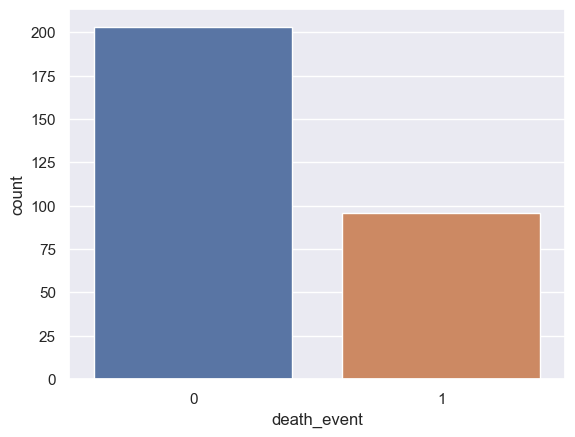

In [991]:
#sns.countplot('death_event', data=data)
sns.countplot(x=data['death_event'])

Зафиксированых случаев смерти почти в два раза меньше чем случев с положительным исходом, таким образом имеется явный дисбаланс классов.

Посмотри еще раз на описание данных с целью понимания разброса значений признаков.

In [992]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.829431,11.894997,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


Итак, почти все признаки, кроме `creatinine_phosphokinase` и `serum_creatinine`, показывают нормальное распределение, поскольку их медиана и среднее значение(второй квартиль) почти совпадают. Для визуализации распределений воспользуемся функцией displot().

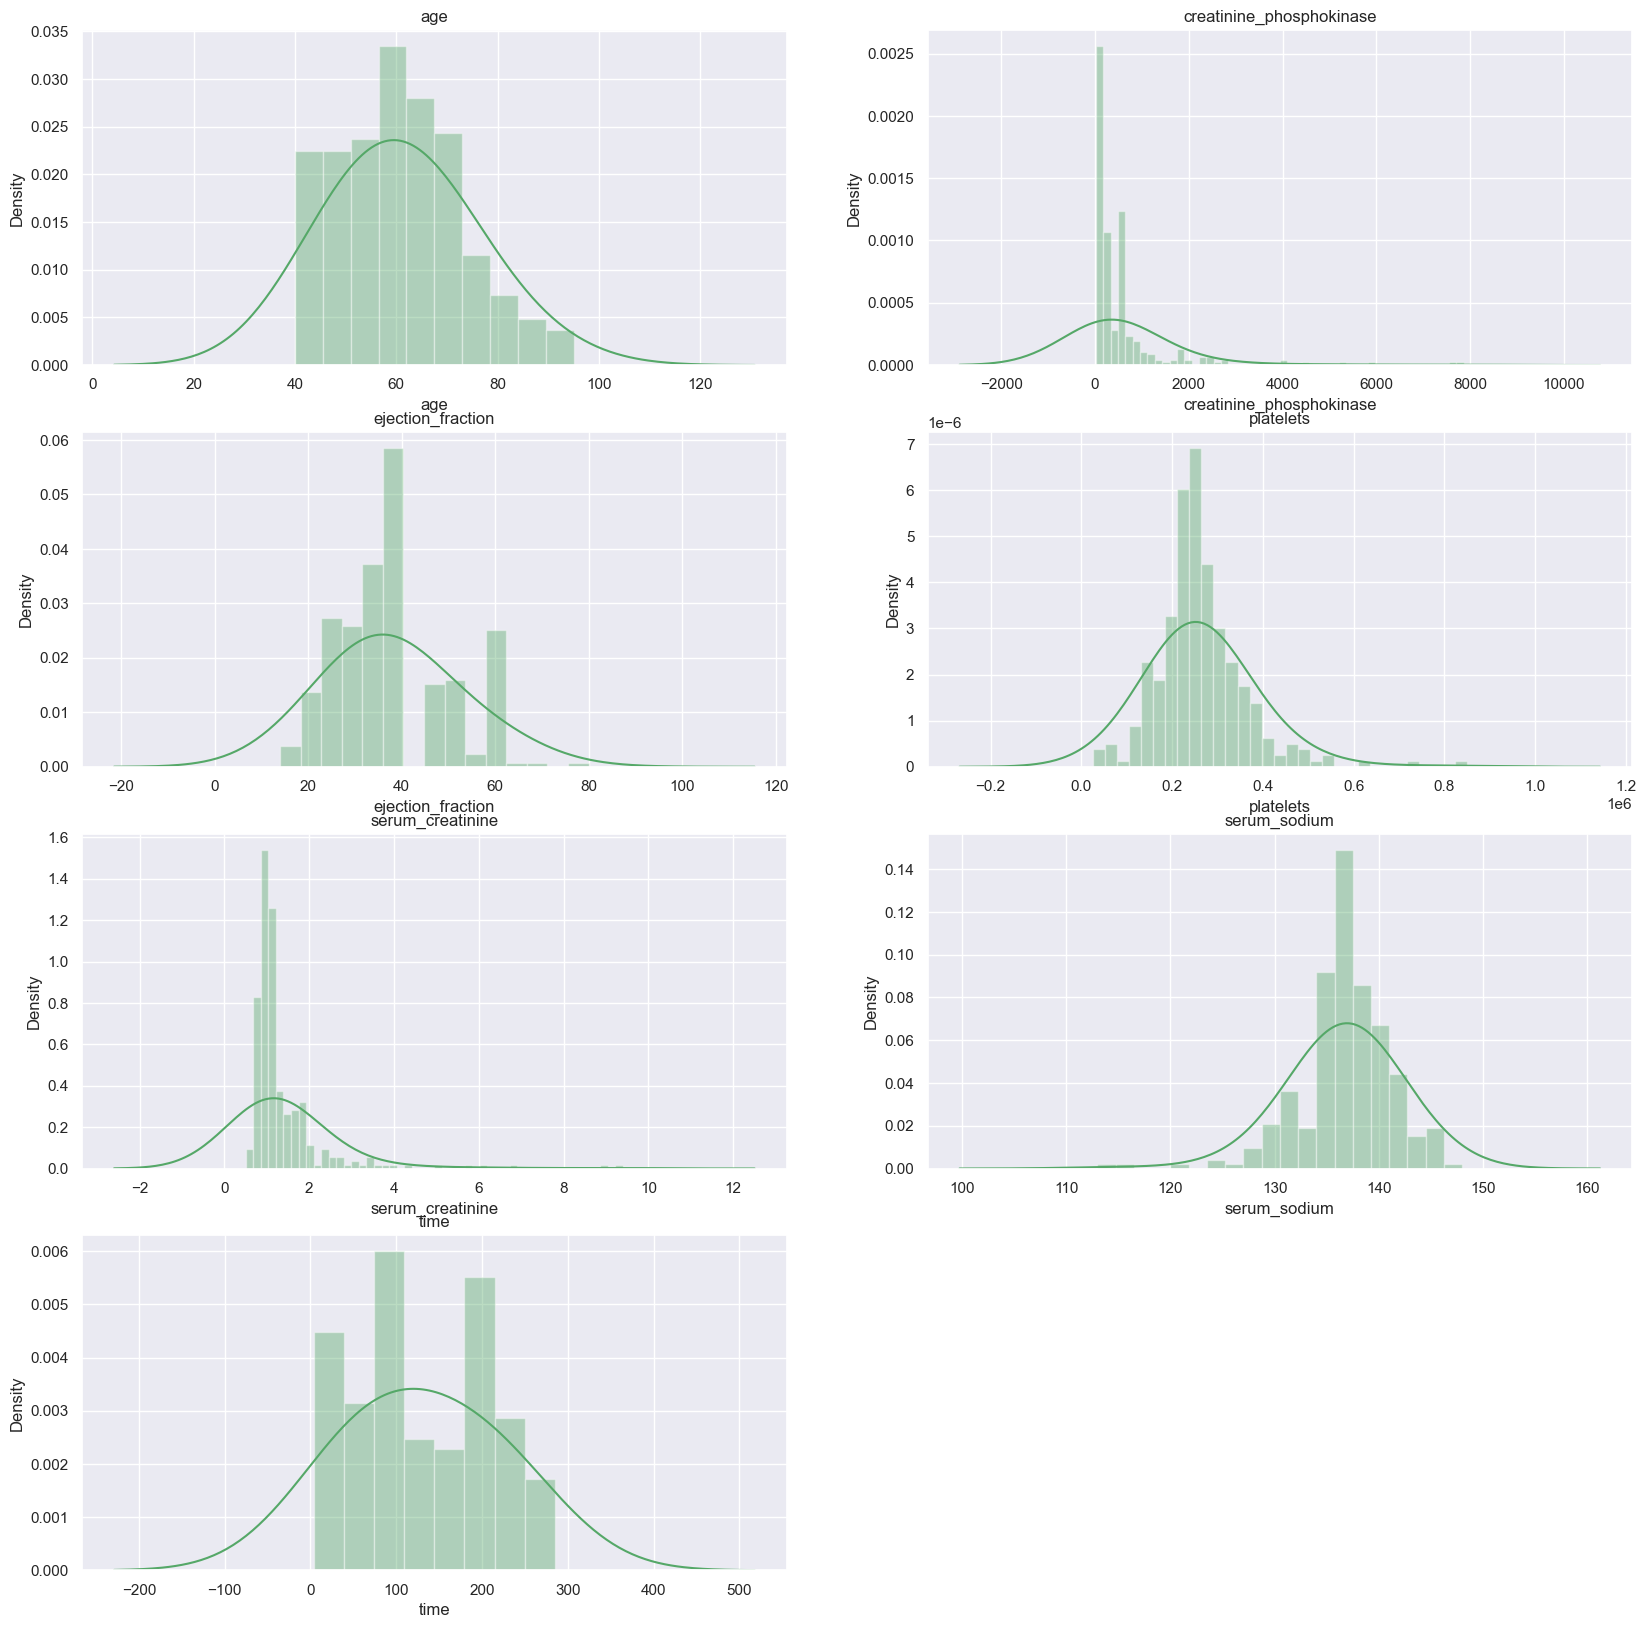

In [993]:
list_of_numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20,20))
for i in range(len(list_of_numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(data[list_of_numerical_features[i]],color = 'g', kde_kws = {'bw' : True});
    title = list_of_numerical_features[i]
    plt.title(title)

In [994]:
#list_of_categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']

#fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,15))
#for i in range(len(list_of_categorical_features)):
    #plt.subplot(3,2,i+1)
    #sns.distplot(data[list_of_categorical_features[i]],color = 'g', kde_kws = {'bw' : True});
    #title = list_of_categorical_features[i]
    #plt.title(title)

Используя тепловую карту, посмторим на корреляцию величин.

<AxesSubplot:>

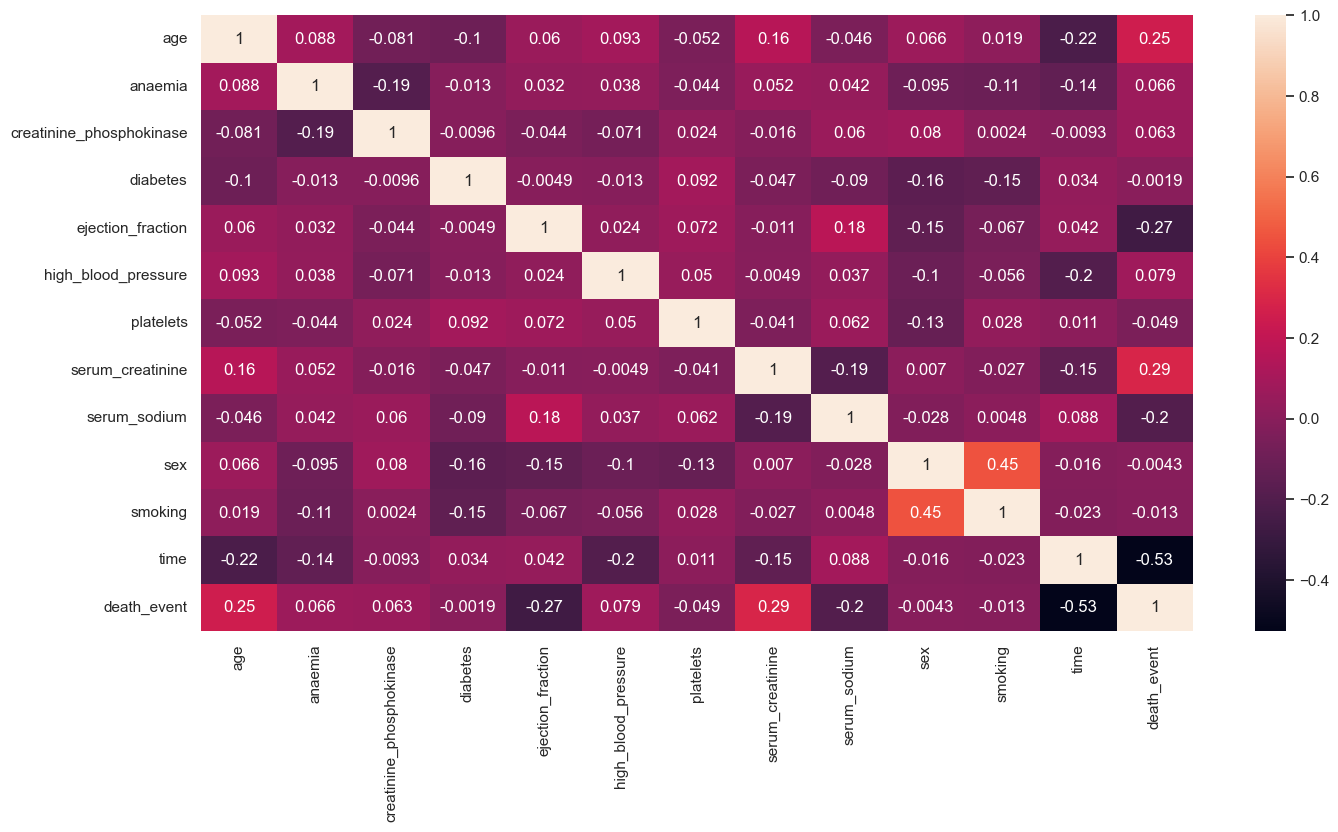

In [995]:
correlation_matrix = data.corr()

plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot = True)

Видим, что положительная корреляция есть между полом и курением. Отрицательная корреляция наблюдается между временем наблюдения и целевым признаком. Несильная связь есть между целевым признаком и возрастом, уровнем креатинина и натрия (разнонаправленные) и размером выброса крови при сокращении сердца. 

##### Категоризация времени, разбиение на недели.

In [996]:
data['time_week'] = (data['time']-1)//7
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,time_week
260,55,0,66,0,40,0,203000.0,1.0,138,1,0,233,0,33
218,68,1,1021,1,35,0,271000.0,1.1,134,1,0,197,0,28
159,59,1,129,0,45,1,362000.0,1.1,139,1,1,121,0,17
284,50,1,54,0,40,0,279000.0,0.8,141,1,0,250,0,35
198,50,1,582,1,20,1,279000.0,1.0,134,0,0,186,0,26
171,52,0,3966,0,40,0,325000.0,0.9,140,1,1,146,0,20
180,40,0,478,1,30,0,303000.0,0.9,136,1,0,148,0,21
214,65,1,135,0,35,1,290000.0,0.8,134,1,0,194,0,27


In [997]:
df_time = pd.DataFrame()

df_time['death'] = data.groupby('time_week')['death_event'].sum()
df_time['count'] = data.groupby('time_week')['death_event'].count()
df_time['percent_of_death'] = round(df_time['death']*100/df_time['count'], 0)

df_time.sort_values(by='percent_of_death', ascending=False)

,death,count,percent_of_death
time_week,,,
0,4,4,100.0
18,2,2,100.0
5,4,4,100.0
6,5,5,100.0
23,1,1,100.0
1,13,14,93.0
3,9,10,90.0
9,5,6,83.0
2,4,5,80.0


<AxesSubplot:xlabel='time_week', ylabel='percent_of_death'>

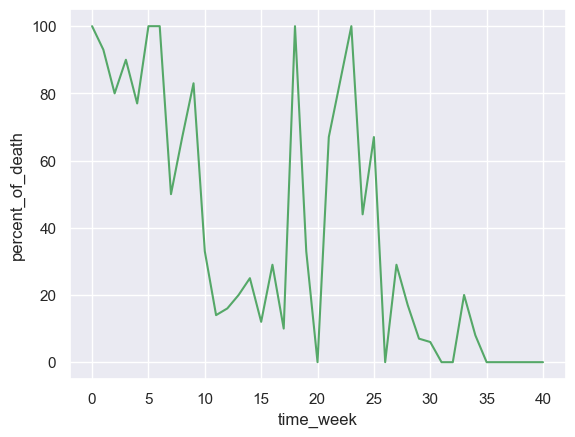

In [998]:
sns.lineplot(data=df_time, x="time_week", y="percent_of_death", color = 'g')

Вот так мы видим, что смертность выше 50% на промежутке наблюдения до 10 недель, между 21 и 24 неделями и на 18-й неделе.

In [999]:
#fig, ax = plt.subplots(nrows = 7,ncols = 1,figsize = (15,40))
#for i in range(len(list_of_numerical_features)):
    #plt.subplot(7,1,i+1)
    #sns.countplot(x = data[list_of_numerical_features[i]],data=data, hue='death_event',color = 'g');
    #title = list_of_numerical_features[i] + ' and death_event' 
    #plt.title(title)

,number_of_death,number_of_observations,mortality_rate
age,,,
40,0,7,0.0
41,0,1,0.0
42,1,7,14.0
43,0,1,0.0
44,0,2,0.0
45,6,19,32.0
46,1,3,33.0
47,0,1,0.0
48,2,2,100.0


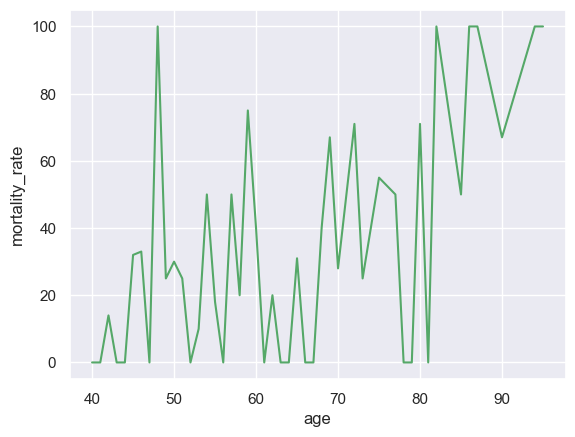

,number_of_death,number_of_observations,mortality_rate
creatinine_phosphokinase,,,
23,1,1,100.0
30,0,1,0.0
47,2,3,67.0
52,0,1,0.0
53,0,1,0.0
...,...,...,...
4540,0,1,0.0
5209,0,1,0.0
5882,1,1,100.0


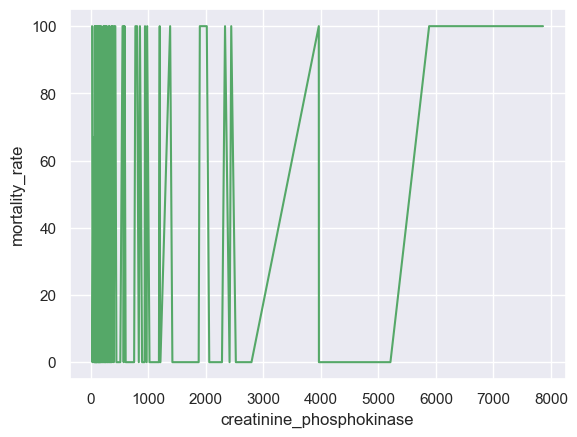

,number_of_death,number_of_observations,mortality_rate
ejection_fraction,,,
14,1,1,100.0
15,2,2,100.0
17,1,2,50.0
20,16,18,89.0
25,18,36,50.0
30,13,34,38.0
35,7,49,14.0
38,15,40,38.0
40,4,37,11.0


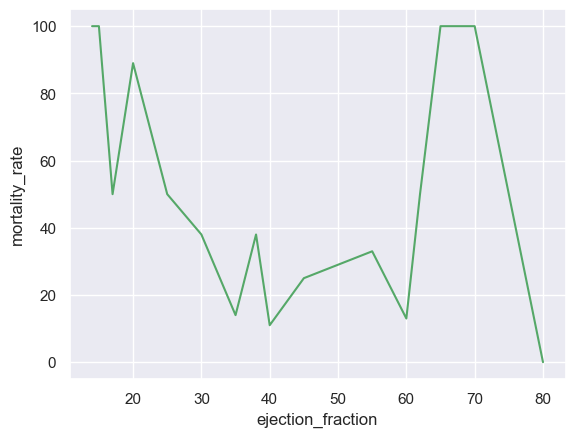

,number_of_death,number_of_observations,mortality_rate
platelets,,,
25100.0,0,1,0.0
47000.0,1,1,100.0
51000.0,0,1,0.0
62000.0,1,1,100.0
70000.0,1,1,100.0
...,...,...,...
533000.0,0,1,0.0
543000.0,0,1,0.0
621000.0,1,1,100.0


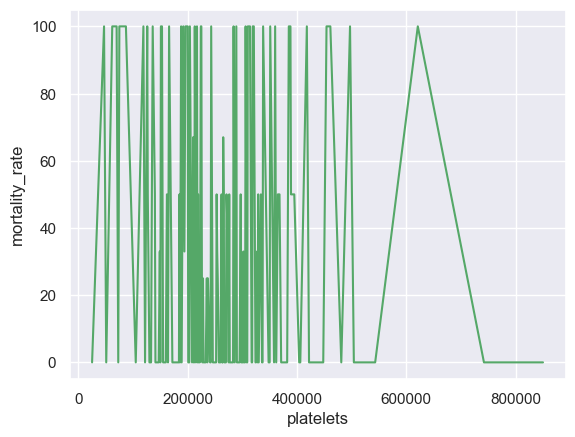

,number_of_death,number_of_observations,mortality_rate
serum_creatinine,,,
0.50,0,1,0.0
0.60,2,4,50.0
0.70,1,19,5.0
0.75,0,1,0.0
0.80,1,24,4.0
0.90,5,32,16.0
1.00,15,50,30.0
1.10,9,32,28.0
1.18,0,11,0.0


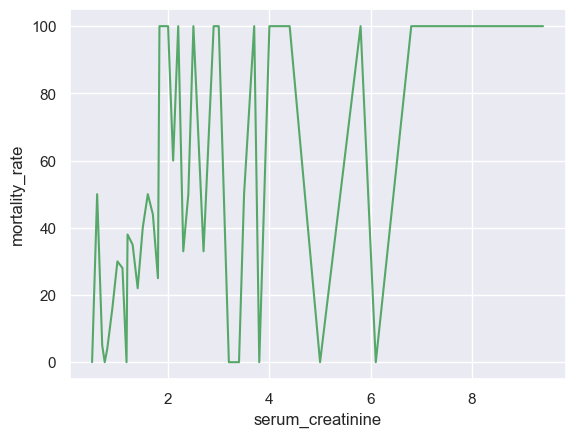

,number_of_death,number_of_observations,mortality_rate
serum_sodium,,,
113,0,1,0.0
116,1,1,100.0
121,1,1,100.0
124,1,1,100.0
125,0,1,0.0
126,0,1,0.0
127,3,3,100.0
128,1,2,50.0
129,2,2,100.0


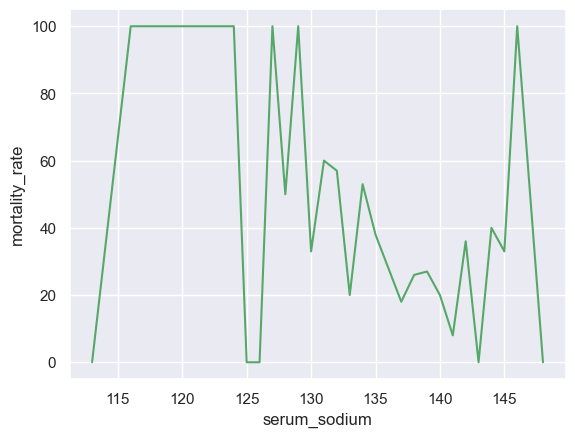

,number_of_death,number_of_observations,mortality_rate
time,,,
4,1,1,100.0
6,1,1,100.0
7,2,2,100.0
8,2,2,100.0
10,6,6,100.0
...,...,...,...
270,0,2,0.0
271,0,1,0.0
278,0,1,0.0


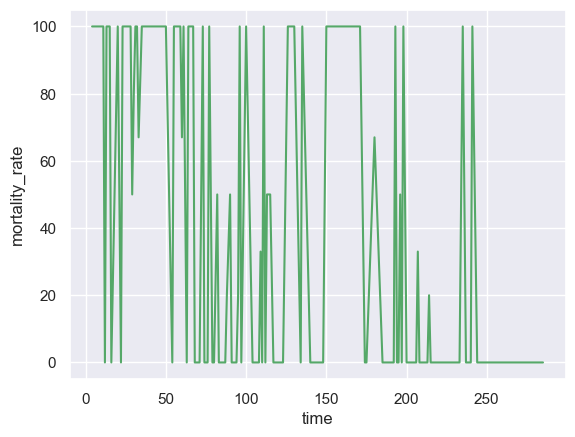

In [1000]:

for i in range(len(list_of_numerical_features)):
    table = data.pivot_table(index=list_of_numerical_features[i], values='death_event', aggfunc=['sum','count'])
    table.columns = ['number_of_death','number_of_observations']
    table['mortality_rate'] = round(table['number_of_death']*100/table['number_of_observations'],0)
    display(table)
    #sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event',color = 'g');
    #title = list_of_categorical_features[i] + ' and death_event' 
    #plt.title(title)
    #plt.show()
    sns.lineplot(data=table, x=list_of_numerical_features[i], y='mortality_rate', color = 'g')
    plt.show()
    
    

In [1001]:
#data['creatinine_phosphokinase'] = data['creatinine_phosphokinase'].map(lambda i: np.log(i) if i>0 else 0)
#table = data.pivot_table(index='creatinine_phosphokinase', values='death_event', aggfunc=['sum','count'])
#table.columns = ['number_of_death','number_of_observations']
#table['mortality_rate'] = round(table['number_of_death']*100/table['number_of_observations'],0)
#display(table)
#sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event',color = 'g');
#title = list_of_categorical_features[i] + ' and death_event' 
#plt.title(title)
#plt.show()
#sns.lineplot(data=table, x='creatinine_phosphokinase', y='mortality_rate', color = 'g')
#plt.show()
#data['creatinine_phosphokinase'].map(lambda i: np.log(i) if i>0 else 0)

Итак, у нас есть 5 категориальных бинарных признаков, таким образом, мы можем рассматривать пациентов сгрупированных по данным признакам, а группы разделить на подгруппы и расчитать процент смертности для каждой из них. На примере анемии: рассмотрим пациентов относительно данного признака, разделим их на две подгруппы, первая из которых - это все те пациенты, у кого была зафиксирована анемия, вторая, наоборот. В каждой из подгруп посчитаем процент смертности, оформим расчеты в сводную таблицу для удобства.

,number_of_death,number_of_observations,mortality_rate
anaemia,,,
0,50,170,0.294118
1,46,129,0.356589


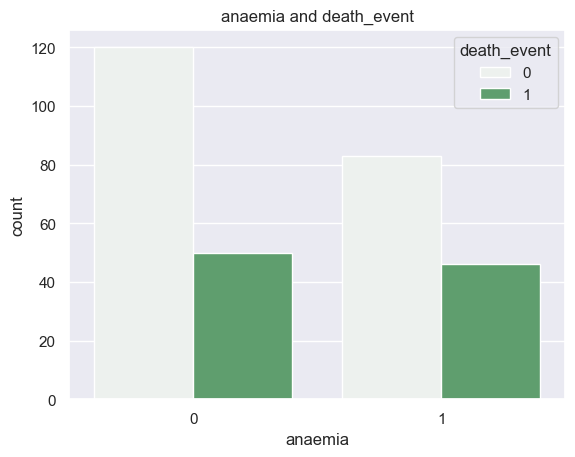

,number_of_death,number_of_observations,mortality_rate
diabetes,,,
0,56,174,0.321839
1,40,125,0.320000


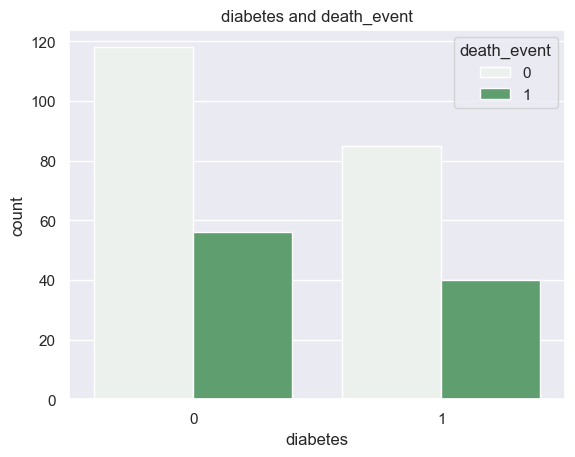

,number_of_death,number_of_observations,mortality_rate
high_blood_pressure,,,
0,57,194,0.293814
1,39,105,0.371429


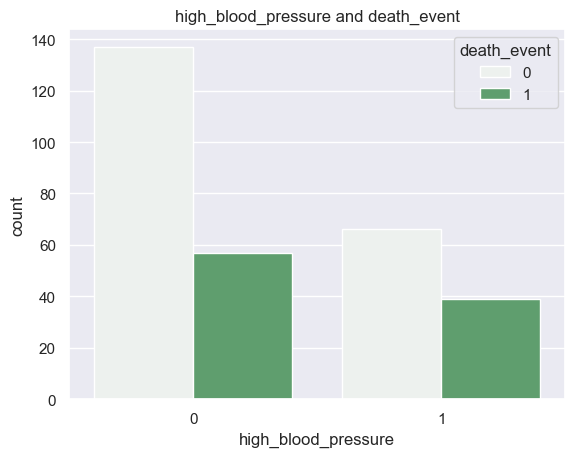

,number_of_death,number_of_observations,mortality_rate
sex,,,
0,34,105,0.323810
1,62,194,0.319588


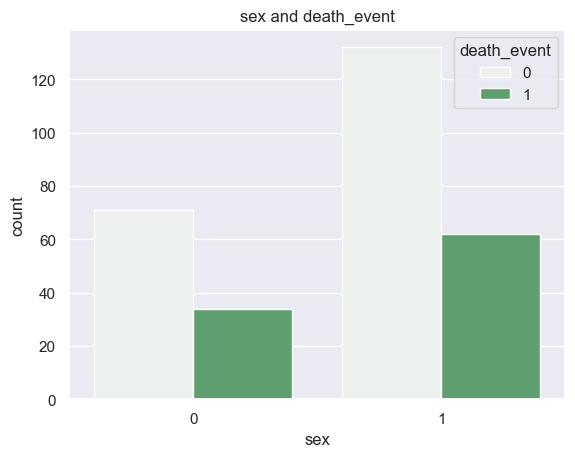

,number_of_death,number_of_observations,mortality_rate
smoking,,,
0,66,203,0.325123
1,30,96,0.312500


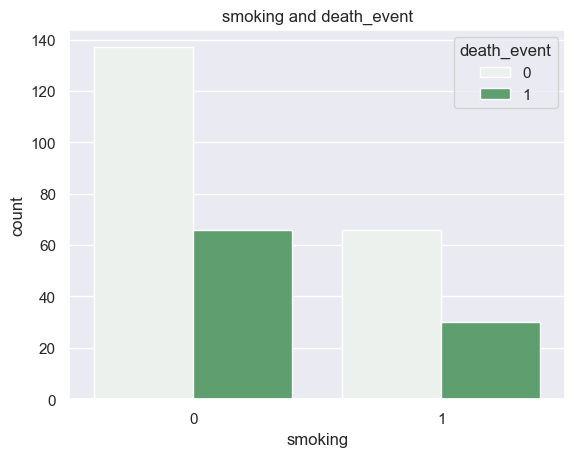

In [1002]:
for i in range(len(list_of_categorical_features)-1):
    table = data.pivot_table(index=list_of_categorical_features[i], values='death_event', aggfunc=['sum','count'])
    table.columns = ['number_of_death','number_of_observations']
    table['mortality_rate'] = table['number_of_death']/table['number_of_observations']
    display(table)
    sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event',color = 'g');
    title = list_of_categorical_features[i] + ' and death_event' 
    plt.title(title)
    plt.show()

1) Согласно графикам и расчетам в таблицах можно отметить следующее: риски смертности увеличивается при наличии анемии и высокого давления, диабет курение и пол не повышают риски;

2) Но, очень важно отметить, что имеется явный перекос в данных, на последнем примере это очень хорошо видно, подгруппа курящих пациентов более чем в два раза меньше подгруппы некурящих, это затрудняет сделать правильный вывод относительно смертности по данному признаку. Это распространяется и на другие группы;

3) Поэтому мы не можем с уверенностью считать, что наши выводы по пункту 1 корректны.

Построим диаграмму размаха.

In [1003]:
list_of_numerical_features = list_of_numerical_features + ['time_week']
list_of_numerical_features.remove('time')

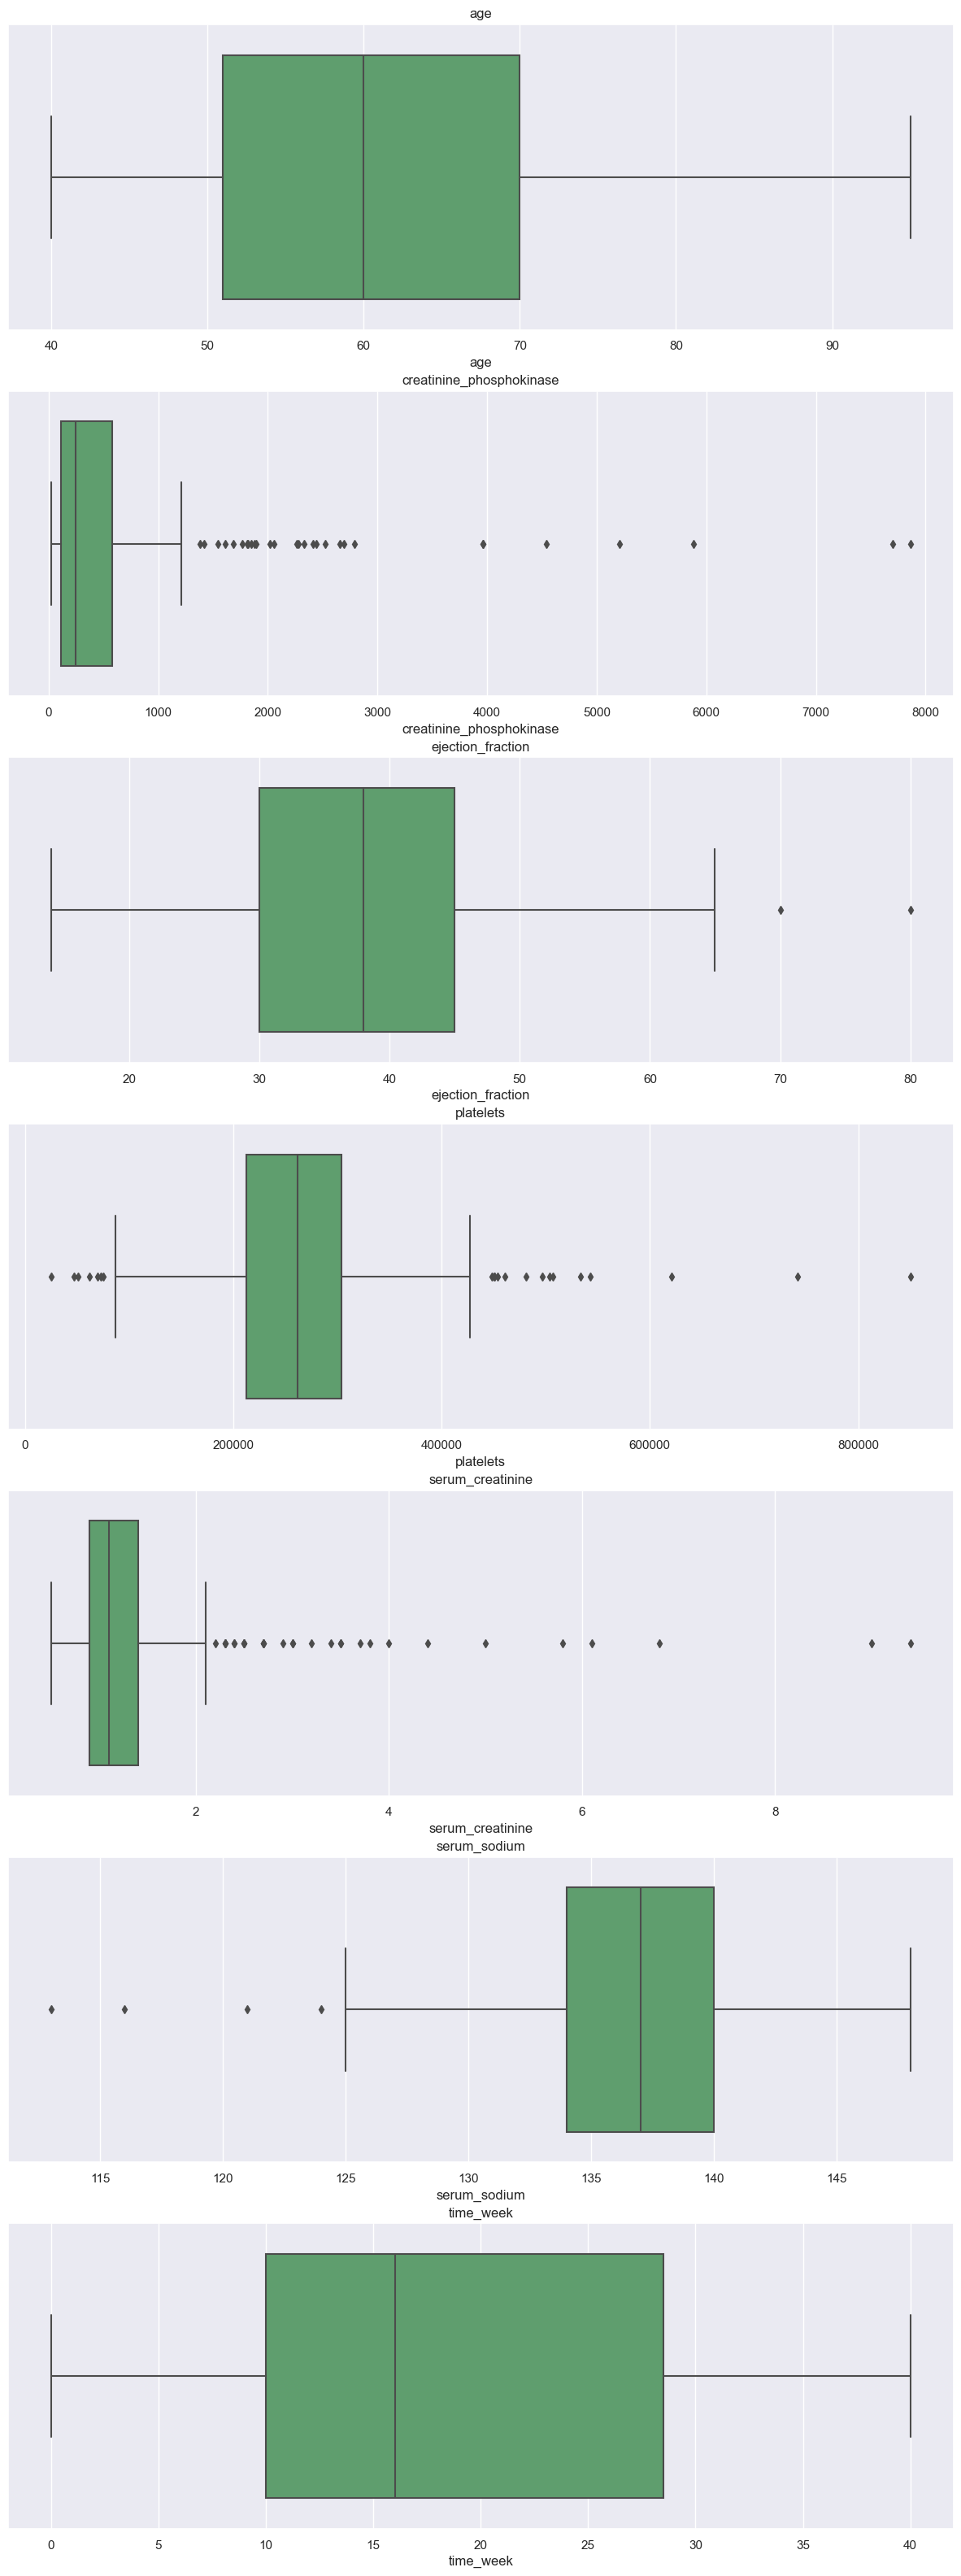

In [1004]:
fig, ax = plt.subplots(nrows = 7,ncols = 1,figsize = (15,40))
for i in range(len(list_of_numerical_features)):
    plt.subplot(7,1,i+1)
    sns.boxplot(x=data[list_of_numerical_features[i]], color='g');
    title = list_of_numerical_features[i] 
    plt.title(title)

Почти во всех признаках наблюдаются выбросы. Учитывая размер и релевантость выборки выбросы удалять не будем.

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,death_event,time_week
0,75,582,20,265000.00,1.9,130,1,0
1,55,7861,38,263358.03,1.1,136,1,0
2,65,146,20,162000.00,1.3,129,1,0
3,50,111,20,210000.00,1.9,137,1,0
4,65,160,20,327000.00,2.7,116,1,1
...,...,...,...,...,...,...,...,...
294,62,61,38,155000.00,1.1,143,0,38
295,55,1820,38,270000.00,1.2,139,0,38
296,45,2060,60,742000.00,0.8,138,0,39
297,45,2413,38,140000.00,1.4,140,0,39


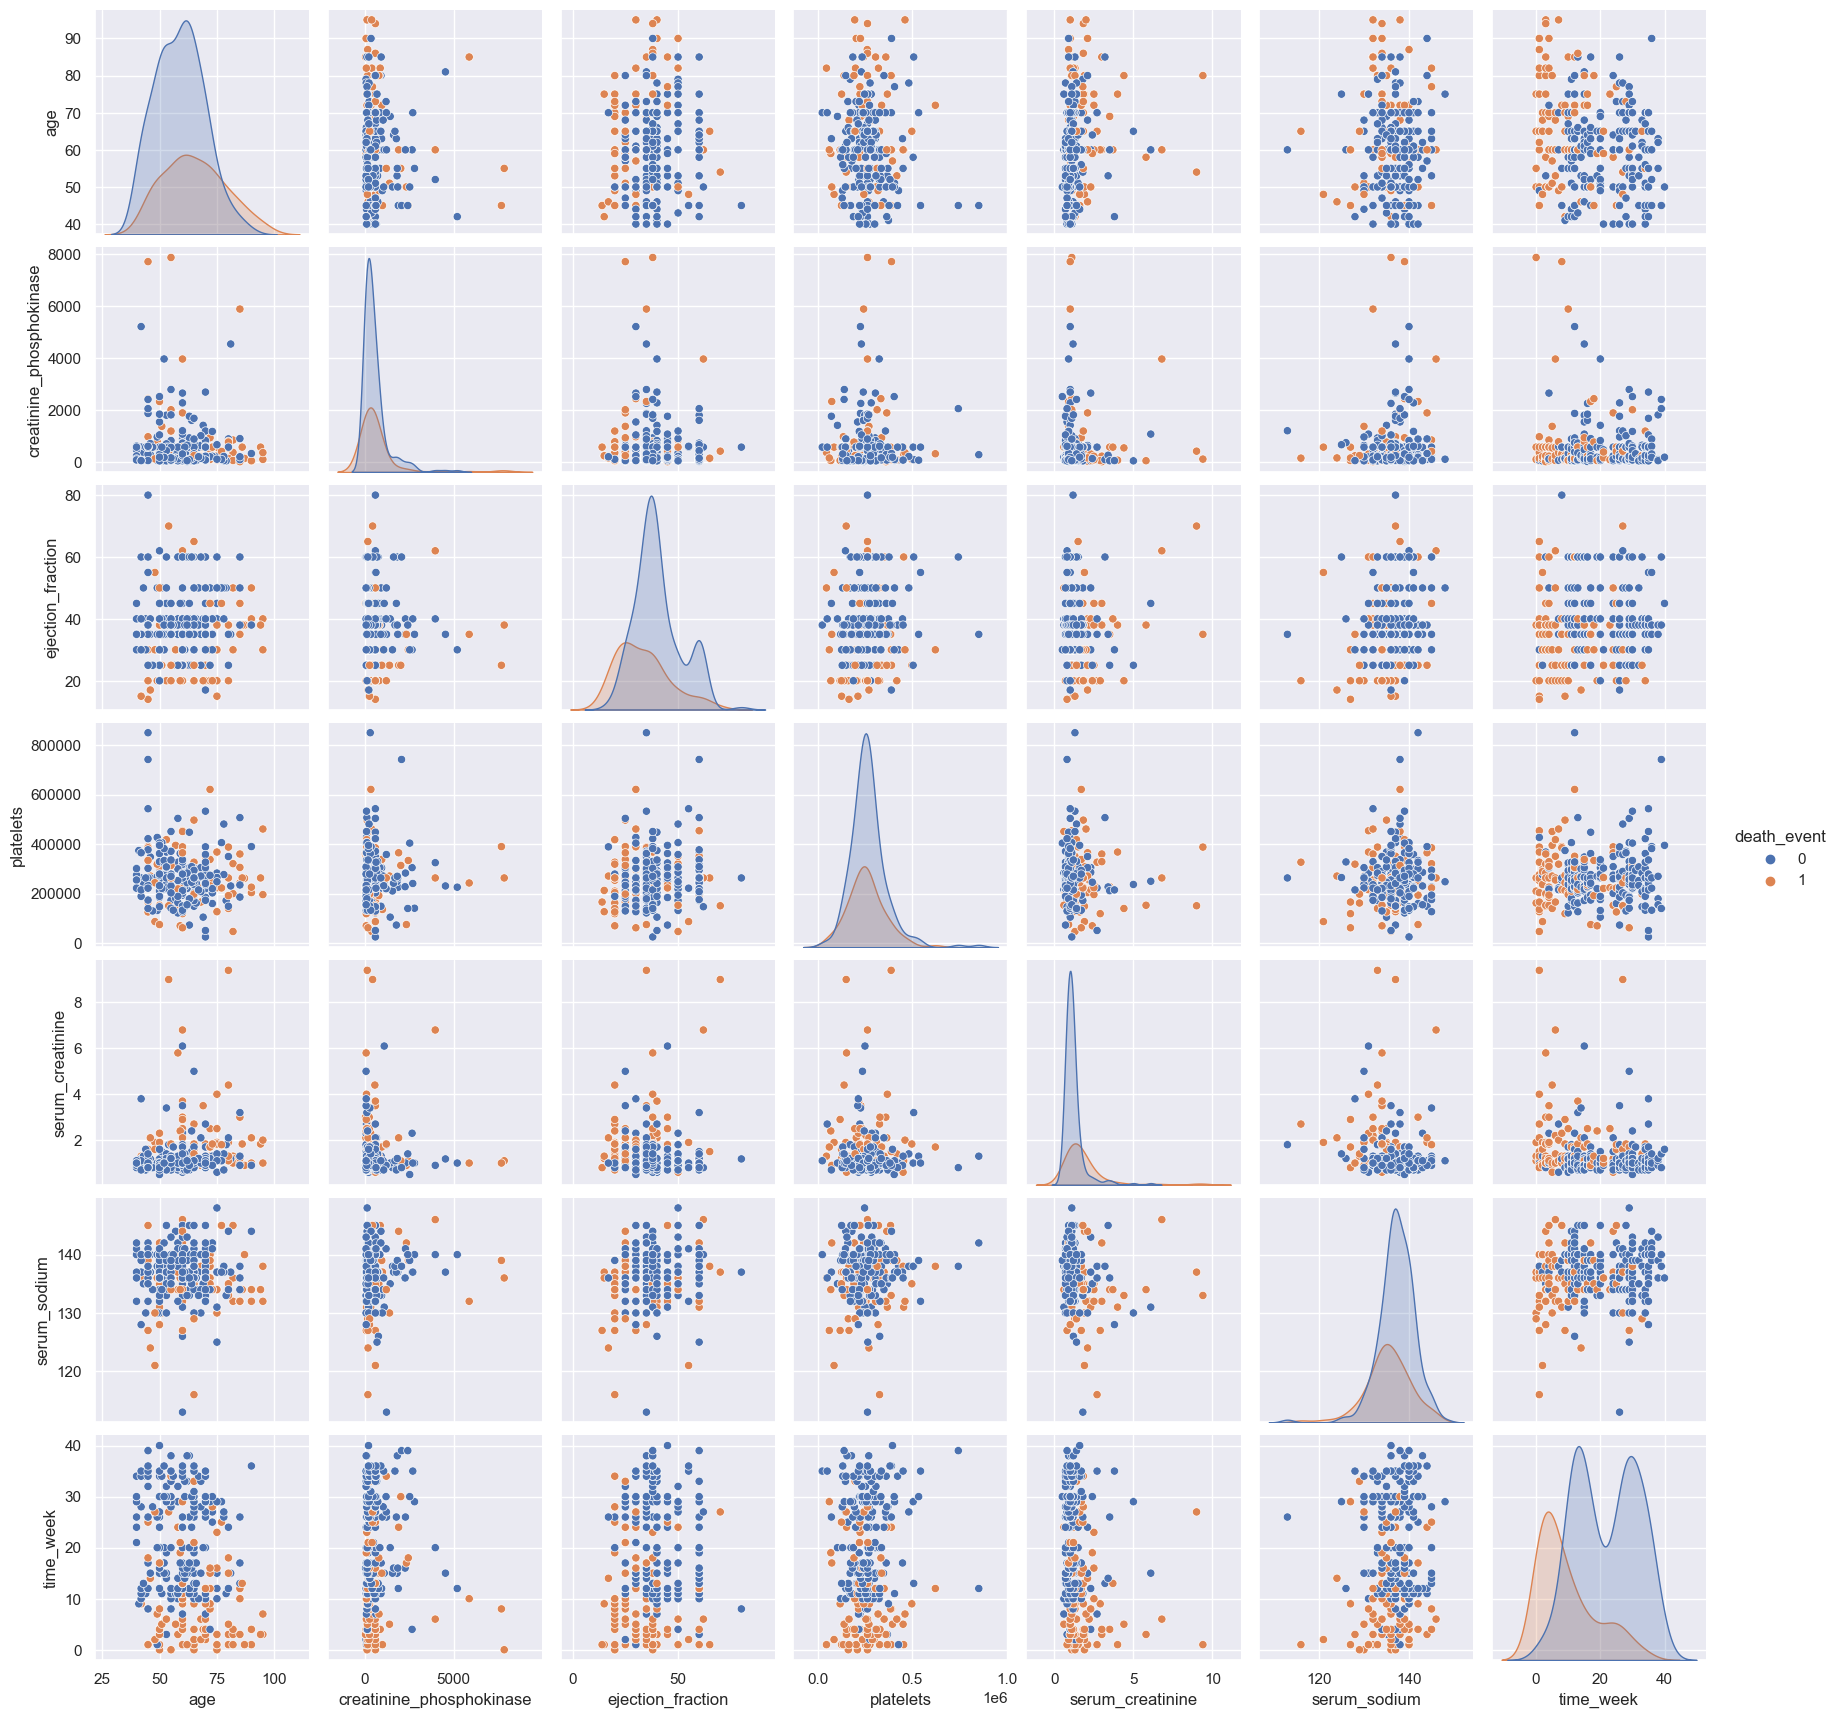

In [1005]:
list_drop = list_of_categorical_features + ['time'] 
list_drop.remove('death_event')
data_numerical = data.drop(list_drop, axis=1)
display(data_numerical)
sns.pairplot(data_numerical, hue='death_event')

Видим, что данные кучкуются в некоторых параметрах (хорошо видно на времени наблюдения, как на первых неделях высока смертность, на объёме сердцебиения можно заметить). По диагональным распределениям можно сказать, что чем сильнее различаются кривые, тем заметней влияние величин друг на друга. Скорее всего, влияние параметра, связанного с тромбоцитами, будет несущественное, его можно исключить из параметров для обучения модели предсказания. Оранжевая кривая полностью скрывается под синей, симметрично и с максимумом на одной оси (визуально).

### Моделирование

 В переменных features_train, target_train и features_test,target_test сохраним данные для тренировки и теста, соответственно. 

In [1010]:
features = data.drop(['death_event'], axis=1) # признаки
target = data['death_event'] # целевые признаки

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)


В качестве метрик используем f1-score, roc_auc_score и recall.
объяснить почему они

In [1011]:
rating_list = {
    'f1-score': [],
    'recall-score': [],
    'roc-auc-score': []
}

In [1012]:
def print_scores(model, features, target):
    score_f1 = cross_val_score(model, features, target, scoring="f1", cv=5)
    score_recall = cross_val_score(model, features, target, scoring="recall", cv=5)
    score_roc_auc = cross_val_score(model, features, target, scoring="roc_auc", cv=5)

    print('Диапазон значений метрик:')
    print('f1-score:', score_f1)
    print("recall-score:", score_recall)
    print("roc-auc-score:", score_roc_auc)
    print('\nСредние значения метрик:')
    print('f1-score:', score_f1.mean())
    print("recall-score:", score_recall.mean())
    print("roc-auc-score:", score_roc_auc.mean())
    #print(sum(score_recall)/len(score_recall))
    
    
    rating_list['f1-score'].append(score_f1.mean())
    rating_list['recall-score'].append(score_recall.mean())
    rating_list['roc-auc-score'].append(score_roc_auc.mean())
    
    # думаю, тут не надо ничего возвращать :)
    # сюда можно встроить функцию записи в табличку/словарь/что-то ещё
    # тогда выбор модели потом можно осуществить на основе анализа этой таблички

In [1013]:
# случайный лес
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
model_forest.fit(features_train, target_train)
# predicted = model.predict(features_test)
# print('f1-score:', f1_score(target_test, predicted))
# print("roc-auc-score:" , roc_auc_score(target_test, predicted))

print_scores(model_forest, features_train, target_train)


Диапазон значений метрик:
f1-score: [0.63636364 0.66666667 0.82758621 0.8125     0.75862069]
recall-score: [0.46666667 0.6        0.8        0.92857143 0.78571429]
roc-auc-score: [0.92020202 0.8959596  0.92222222 0.95063025 0.92532468]

Средние значения метрик:
f1-score: 0.7403474399164054
recall-score: 0.7161904761904762
roc-auc-score: 0.9228677531618708


In [1014]:
# логистическая регрессия
model_log = LogisticRegression(random_state=RANDOM_STATE)
model_log.fit(features_train, target_train)

print_scores(model_log, features_train, target_train)



Диапазон значений метрик:
f1-score: [0.60869565 0.68965517 0.64285714 0.59259259 0.88888889]
recall-score: [0.46666667 0.66666667 0.6        0.57142857 0.85714286]
roc-auc-score: [0.84242424 0.77575758 0.84646465 0.82563025 0.97402597]

Средние значения метрик:
f1-score: 0.6845378897852661
recall-score: 0.6323809523809524
roc-auc-score: 0.8528605381546557


In [1015]:
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)
model_cat.fit(features_train, target_train)

print_scores(model_cat, features_train, target_train)


Диапазон значений метрик:
f1-score: [0.63636364 0.66666667 0.85714286 0.8        0.68965517]
recall-score: [0.46666667 0.6        0.8        0.85714286 0.71428571]
roc-auc-score: [0.93333333 0.87474747 0.9030303  0.95378151 0.93506494]

Средние значения метрик:
f1-score: 0.7299656665173906
recall-score: 0.6876190476190477
roc-auc-score: 0.9199915117562177


In [1016]:
rating_table = {
    'Model': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'],
    'f1-score': rating_list['f1-score'],
    'recall-score': rating_list['recall-score'],
    'roc-auc-score': rating_list['roc-auc-score']
}
rating_table = pd.DataFrame(rating_table)
rating_table.sort_values('f1-score', ascending=False).style.highlight_max(subset=['f1-score', 'recall-score', 'roc-auc-score'])

,Algoritm,f1-score,recall-score,roc-auc-score
0,RandomForestClassifier,0.740347,0.716190,0.922868
2,CatBoostClassifier,0.729966,0.687619,0.919992
1,LogisticRegression,0.684538,0.632381,0.852861


Таким образом,случайный лес имеет лучшие оценки на валидационных данных.

### Подбор параметров
Подберём параметры для каждой модели. Критерием будет метрика recall.

In [869]:
# баланс классов
#target_train.value_counts(normalize=True)

0    0.694561
1    0.305439
Name: death_event, dtype: float64

In [870]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)

In [871]:
rating_list = {
    'f1-score': [],
    'recall-score': [],
    'roc-auc-score': []
}

#### случайный лес

In [872]:
parameters = {'n_estimators' : range (1, 100, 2), 
              'max_depth' : range (1, 20, 2), 
              'bootstrap' : ('True', 'False'),
              'class_weight':('balanced', 'None','balanced_subsample', [0.30, 0.70], [0.70, 0.30])
             }

grid_forest = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), parameters, scoring="recall", cv = 5, n_jobs= -1)   # , class_weight = 'balanced'
grid_forest.fit(features_train_scaled, target_train)

grid_forest.best_params_

{'bootstrap': 'True',
 'class_weight': 'balanced',
 'max_depth': 1,
 'n_estimators': 11}

In [873]:
model_forest = RandomForestClassifier(n_estimators=grid_forest.best_params_.get('n_estimators'),\
                                      max_depth=grid_forest.best_params_.get('max_depth'),\
                                      bootstrap=grid_forest.best_params_.get('bootstrap'), random_state=RANDOM_STATE, class_weight=grid_forest.best_params_.get('class_weight'))

print_scores(model_forest, features_train_scaled, target_train)

Диапазон значений метрик:
f1-score: [0.66666667 0.83870968 0.8        0.83870968 0.78787879]
recall-score: [0.6        0.86666667 0.8        0.92857143 0.92857143]
roc-auc-score: [0.88282828 0.88888889 0.86161616 0.95693277 0.93398268]

Средние значения метрик:
f1-score: 0.7863929618768329
recall-score: 0.8247619047619048
roc-auc-score: 0.9048497580850523


In [874]:
print(grid_forest.best_score_)

0.8247619047619048


#### логистическая регрессия

In [875]:
parameters = {'solver':('liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'), 
              'max_iter': range(1,120, 10),
              'class_weight':('balanced', 'None', [0.30, 0.70], [0.70, 0.30])
             }  

grid_log = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), parameters, scoring="recall", cv = 5)#n_jobs= -1)
grid_log.fit(features_train_scaled, target_train)

grid_log.best_params_

{'class_weight': 'balanced', 'max_iter': 1, 'solver': 'sag'}

In [876]:
model_log = LogisticRegression(solver=grid_log.best_params_.get('solver'),\
                               max_iter=grid_log.best_params_.get('max_iter'),\
                               class_weight=grid_log.best_params_.get('class_weight'), random_state=RANDOM_STATE)

print_scores(model_log, features_train_scaled, target_train)

Диапазон значений метрик:
f1-score: [0.8        0.72727273 0.66666667 0.64864865 0.75675676]
recall-score: [0.8        0.8        0.86666667 0.85714286 1.        ]
roc-auc-score: [0.91717172 0.84646465 0.85454545 0.87394958 0.96969697]

Средние значения метрик:
f1-score: 0.7198689598689599
recall-score: 0.8647619047619048
roc-auc-score: 0.8923656735421442


In [877]:
print(grid_log.best_score_)

0.8647619047619048


#### CatBoost

In [878]:
parameters_cat = {'l2_leaf_reg': range (1, 15, 2), 
                  'iterations' : range(1, 100, 10),
                  'learning_rate':[0.03, 0.07, 0.1, 0.13, 0.17],
                  'max_depth' : range(1, 10, 2),
                 }

grid_cat = GridSearchCV(CatBoostClassifier(random_state=RANDOM_STATE),\
                        parameters_cat, scoring="recall",  cv = 5, n_jobs= -1)
grid_cat.fit(features_train_scaled, target_train, silent=True)
grid_cat.best_params_

{'iterations': 81, 'l2_leaf_reg': 3, 'learning_rate': 0.17, 'max_depth': 5}

In [879]:
model_cat = CatBoostClassifier(l2_leaf_reg=grid_cat.best_params_.get('l2_leaf_reg'),\
                               iterations=grid_cat.best_params_.get('iterations'),\
                               learning_rate=grid_cat.best_params_.get('learning_rate'),\
                               max_depth=grid_cat.best_params_.get('max_depth'),\
                               random_state=RANDOM_STATE, silent=True)

print_scores(model_cat, features_train_scaled, target_train)

Диапазон значений метрик:
f1-score: [0.75       0.66666667 0.82758621 0.85714286 0.75862069]
recall-score: [0.6        0.6        0.8        0.85714286 0.78571429]
roc-auc-score: [0.9030303  0.87474747 0.91717172 0.94957983 0.92640693]

Средние значения метрик:
f1-score: 0.7720032840722496
recall-score: 0.7285714285714285
roc-auc-score: 0.9141872506578389


In [880]:
print(grid_cat.best_score_)

0.7285714285714285


In [881]:
rating_table = {
    'Algoritm': ['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'],
    'f1-score': rating_list['f1-score'],
    'recall-score': rating_list['recall-score'],
    'roc-auc-score': rating_list['roc-auc-score']
}
rating_table = pd.DataFrame(rating_table)
rating_table.sort_values('recall-score', ascending=False).style.highlight_max(subset=['f1-score', 'recall-score', 'roc-auc-score'])

,Algoritm,f1-score,recall-score,roc-auc-score
1,LogisticRegression,0.719869,0.864762,0.892366
0,RandomForestClassifier,0.786393,0.824762,0.904850
2,CatBoostClassifier,0.772003,0.728571,0.914187


### Тестирование

<font color='green'> C масштабированием ситуация прменялась-по recall выбираем логистическую регрессию, по f1 катбуст, но если мы остановились на recall, то тогда берем лог регрессию.</font>

In [882]:
scaler = StandardScaler()
scaler.fit(features_test) 
features_test_scaled = scaler.transform(features_test)

#model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=120, class_weight='balanced')
best_model= model_log.fit(features_train_scaled, target_train)
predictions = best_model.predict(features_test_scaled)
#print("f1-score для логистической регрессии:", f1_score(target_test, predictions_test_LogisticRegression))
print('f1-score:', f1_score(target_test, predictions))
print('recall-score:', recall_score(target_test, predictions))
print("roc-auc-score:" , roc_auc_score(target_test, predictions))

f1-score: 0.7083333333333334
recall-score: 0.7391304347826086
roc-auc-score: 0.7614571092831962


<AxesSubplot:>

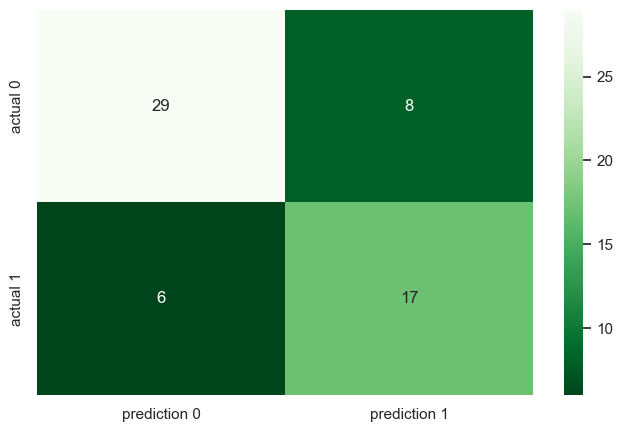

In [904]:
conf_matrix = confusion_matrix(target_test, predictions)
table_conf_matrix = pd.DataFrame(data=conf_matrix, columns=['prediction 0','prediction 1'], index=['actual 0','actual 1'])
#labels = ['True Neg','False Pos','False Neg','True Pos']
#labels = np.asarray(labels).rashape(2,2)
plt.figure(figsize = (8,5))
sns.heatmap(table_conf_matrix, annot=True, cmap='Greens_r')

Оценка точности на тестовой выборке 0.739 по метрике recall.

In [34]:
#len(features_train) # зафиксировать размер, чтоб понять, сколько строк ушло.

In [35]:
def del_quantile(df, param_name):
    q1 = df[param_name].quantile(.25)
    q3 = df[param_name].quantile(.75)

    q0 = q1 - (q3-q1)*1.5
    q4 = q3 + (q3-q1)*1.5

    return df.loc[(df[param_name]>q0) & (df[param_name]<q4)]

In [36]:
#for item in list_of_numerical_features:
#    features_train = del_quantile(features_train, item)

In [37]:
#len(features_train)